In [5]:
import numpy as np
import torch 
import matplotlib.pyplot as plt
import torch.nn.functional as F
torch.set_grad_enabled(False)
torch.set_default_device("cuda")

def fdm(U, kernel, axis):
    N = U.shape[1:]
    kernel = kernel.view(1,1,-1)
    ell = (kernel.shape[2]-1)//2

    if axis == 0: V = torch.cat((U[:,-ell:,:], U, U[:,:ell,:]), dim=1)
    elif axis == 1: V = torch.cat((U[:,:,-ell:], U, U[:,:,:ell]), dim=2)
    if axis == 0: V = V.permute(0,2,1)
    V = V.reshape(-1, 1, N[axis]+2*ell)
    V = F.conv1d(V, kernel)
    V = V.reshape(-1, *N)
    if axis == 0: V = V.permute(0,2,1)
    return V

# coefficients
dx = torch.tensor([1/280, -4/105, 1/5, -4/5, 0, 4/5, -1/5, 4/105, -1/280 ]).double()
dxx = torch.tensor([-1/560, 8/315, -1/5, 8/5, -205/72, 8/5, -1/5, 8/315, -1/560 ]).double()
dxxxx = torch.tensor([7/240, -2/5, 169/60, -122/15, 91/8, -122/15, 169/60, -2/5, 7/240 ]).double()

def laplace(U, hx):
    Dxx = fdm(U, dxx, axis=0) / hx**2
    Dyy = fdm(U, dxx, axis=1) / hx**2
    return Dxx + Dyy

def biharmonic(U, hx):
    Dxxyy = fdm(fdm(U, dxx, axis=0), dxx, axis=1) / hx**4
    Dxxxx = fdm(U, dxxxx, axis=0) / hx**4
    Dyyyy = fdm(U, dxxxx, axis=1) / hx**4
    return 2*Dxxyy + Dxxxx + Dyyyy

def grad(U, hx):
    Dx = fdm(U, dx, axis=0) / hx
    Dy = fdm(U, dx, axis=1) / hx
    return torch.stack((Dx, Dy), dim=1)

def ks(U, hx):
    # grad_squared = grad(U,hx).pow(2).sum(dim=1)
    grad_squared = 0.5*laplace(U**2,hx)-U*laplace(U,hx)
    return - laplace(U,hx) - biharmonic(U,hx) - 0.5*grad_squared 

def rk4(U,f,dt):
    k1 = f(U)
    k2 = f(U + dt / 2 * k1)
    k3 = f(U + dt / 2 * k2)
    k4 = f(U + dt * k3)
    return U + dt/6*(k1+2*k2+2*k3+k4)

# simulation in shenfun is done w/
# - ht = 0.01
# - recording the state every 50 iterations
U = np.load("../ks2d/ks2d_long.npy")
U = torch.tensor(U).double()

# simulation parameters
L = 60 * torch.pi
hx = L / 256
ht = 0.001
steps = 10

T = int(steps * (50 * 0.01) / ht)
U_sim = U[0,None,...]

%matplotlib qt
im = plt.imshow(U_sim[0,...].cpu().numpy())
for i in range(T-1):
    U_sim = rk4(U_sim, lambda u: ks(u,hx), ht)
    # U_sim = U_sim - U_sim.mean() # normalizes the energy level... it helps a lot...
    if i % 20 == 0:
        im.set_data(U_sim[0,...].cpu().numpy())
        plt.pause(0.000001)
        plt.draw()
U_sim = U_sim[0,...]
plt.show()

KeyboardInterrupt: 

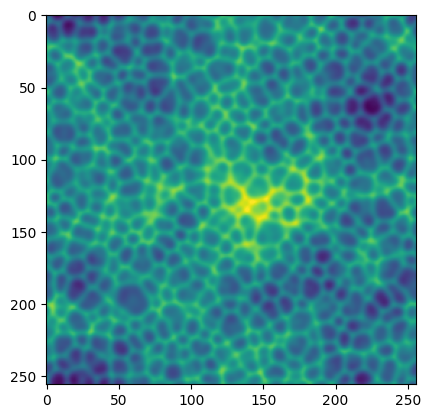

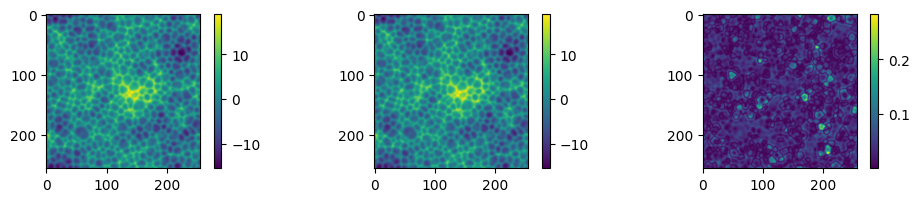

In [3]:
%matplotlib inline
fig, ax = plt.subplots(1,3,figsize=(12,2))
plt.colorbar(ax[0].imshow(U[steps,...].cpu()))
plt.colorbar(ax[1].imshow(U_sim.cpu()))
plt.colorbar(ax[2].imshow( (U[steps,...]-U_sim).abs().cpu() ))
plt.show()